In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv3D, Flatten,MaxPooling2D, MaxPooling3D,AveragePooling3D, concatenate,Input ,SpatialDropout3D,Dropout
import keras
from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from keras.optimizers import SGD,RMSprop
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SVMSMOTE


In [36]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
yAll_Old=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2014-12-31'))


In [28]:
yAll1=xr.where(yAll_Old<12,0,5)

In [4]:
#Surface data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')


In [5]:
rh = (e**((17.625*(d2mData.d2m.values-273.15))/(243.04+(d2mData.d2m.values-273.15)))/e**((17.625*(t2mData.t2m.values-273.15))/(243.04+(t2mData.t2m.values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [6]:
rh = rh_ds.rh

In [7]:
#rh=rh_ds.rh.shift(time=1)

In [8]:
y=yAll.sel(time=slice('1980-1-1','2014-12-31'))

In [9]:
rhTsAll  = rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))

In [10]:
rhTs=rhTsAll.sel(time=slice('1980-1-1','2014-12-31'))

In [11]:
rhTs=rhTs.values
rhTs=rhTs[:,:,:,None]
rhTs.shape

(2170, 18, 26, 1)

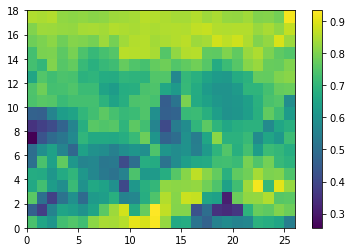

In [12]:
c = plt.pcolor(rhTs[0,:,:,0])
plt.colorbar(c)

In [78]:
itx = np.where(y==0)

In [91]:
import random

itx_ = random.sample(itx[0].tolist(),500)

In [37]:
rhTso = rhTs[:,:,:]
yo    = yAll_Old[:] 

In [81]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(2,2), activation='relu',
                 input_shape=(rhTso.shape[1],
                              rhTso.shape[2],1)),)
model.add(Conv2D(32, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
#model.add(MaxPooling2D(pool_size=4))


model.add(Conv2D(64, kernel_size=(2,2), activation='relu'))
model.add(Conv2D(64, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation = 'linear'))

In [82]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 17, 25, 32)        160       
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 16, 24, 32)        4128      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 8, 12, 32)         0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 7, 11, 64)         8256      
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 6, 10, 64)         16448     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 3, 5, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 960)              

In [14]:
rhTso.shape

(2170, 18, 26, 1)

In [39]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [73]:
model = Sequential()
model.add(Conv2D(input_shape=(18,26,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(1,1)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(1,1)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1, activation="linear"))

In [83]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.mse, metrics=['mse'])

In [92]:
history = model.fit(rhTso, yo,epochs=60)
yy_test = model.predict(rhTso)

#cm=confusion_matrix(yo, yy_test)

#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot() 

Epoch 1/60
68/68 [==============================] - 1s 6ms/step - loss: 4.6581 - mse: 4.6581
Epoch 2/60
68/68 [==============================] - 0s 6ms/step - loss: 4.1388 - mse: 4.1388
Epoch 3/60
68/68 [==============================] - 0s 6ms/step - loss: 4.3994 - mse: 4.3994
Epoch 4/60
68/68 [==============================] - 0s 6ms/step - loss: 4.5343 - mse: 4.5343
Epoch 5/60
68/68 [==============================] - 0s 6ms/step - loss: 3.8251 - mse: 3.8251
Epoch 6/60
68/68 [==============================] - 0s 6ms/step - loss: 3.7836 - mse: 3.7836
Epoch 7/60
68/68 [==============================] - 0s 6ms/step - loss: 3.5413 - mse: 3.5413
Epoch 8/60
68/68 [==============================] - 0s 6ms/step - loss: 3.3209 - mse: 3.3209
Epoch 9/60
68/68 [==============================] - 0s 6ms/step - loss: 3.0986 - mse: 3.0986
Epoch 10/60
68/68 [==============================] - 0s 6ms/step - loss: 3.5125 - mse: 3.5125
Epoch 11/60
68/68 [==============================] - 0s 6ms/step - lo

In [93]:
yy_test

array([[ 7.4434114],
       [10.404143 ],
       [ 9.610148 ],
       ...,
       [18.539762 ],
       [16.919958 ],
       [18.956644 ]], dtype=float32)

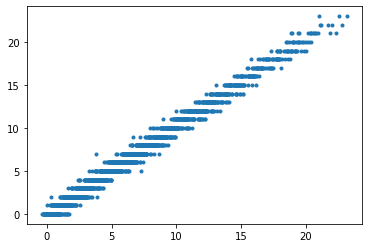

In [94]:
plt.plot(yy_test,yo,'.')


In [95]:
np.corrcoef(yy_test[:,0],yo[:])

array([[1.        , 0.99323957],
       [0.99323957, 1.        ]])

Epoch 1/15
16/16 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 2/15
16/16 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 3/15
16/16 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 4/15
16/16 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 5/15
16/16 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 6/15
16/16 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 7/15
16/16 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 8/15
16/16 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 9/15
16/16 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 10/15
16/16 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 

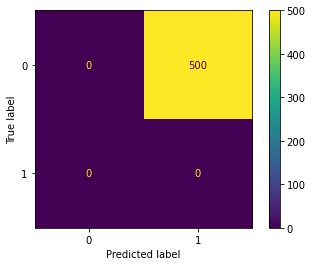

In [156]:
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics='acc')

history = model.fit(rhTso, yo, epochs=5)
yy_test = model.predict(rhTso)

cm=confusion_matrix(yo, yy_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

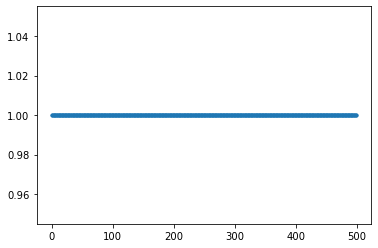

In [130]:
plt.plot(yy_test,'.')